<a href="https://colab.research.google.com/github/awiteck/DeepLearningProject/blob/main/yolo_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Input, Dense, Reshape
import tensorflow.keras.backend as K # For custom loss function
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1: Load in data and make it more robust.

Code adapted from https://www.kaggle.com/code/balraj98/yolo-v5-car-object-detection

In [3]:
data_path = "/content/drive/MyDrive/DeepLearningProject/data"

In [4]:
df = pd.read_csv(f'{data_path}/train_solution_bounding_boxes.csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,304.493488,205.130309,46.468886,36.190476,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,67.746744,211.732625,105.166425,49.395109,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,300.580318,206.597490,122.775687,59.665380,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,563.251809,201.951416,133.536903,59.176319,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,74.594790,212.466216,115.927641,51.840412,0


In [5]:
df

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,304.493488,205.130309,46.468886,36.190476,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,67.746744,211.732625,105.166425,49.395109,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,300.580318,206.597490,122.775687,59.665380,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,563.251809,201.951416,133.536903,59.176319,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,74.594790,212.466216,115.927641,51.840412,0
...,...,...,...,...,...,...,...,...,...,...
554,vid_4_9860,0.000000,198.321729,49.235251,236.223284,24.617626,217.272506,49.235251,37.901554,0
555,vid_4_9880,329.876184,156.482351,536.664239,250.497895,433.270211,203.490123,206.788055,94.015544,0
556,vid_4_9900,0.000000,168.295823,141.797524,239.176652,70.898762,203.736237,141.797524,70.880829,0
557,vid_4_9960,487.428988,172.233646,616.917699,228.839864,552.173343,200.536755,129.488711,56.606218,0


Step 2: Normalize values (model will predict `x_center` and `y_center`, as well as `w` and `h`, so we only have to normalize those)

In [6]:
img_h, img_w, num_channels = (380, 676, 3)
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
# df = df.drop('image_id', 1)
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


**Preliminary visualization**

In [7]:
img_ids = ["vid_4_1000", "vid_4_10000", "vid_4_30440"]

In [8]:
imgs = [cv2.imread(f"{data_path}/training_images/{img_ids[i]}.jpg") for i in range(len(img_ids))]
bboxs = [df[df['image_id'] == img_ids[i]] for i in range(len(img_ids))]

In [9]:
def visualize_bbox(img, bbox):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox.iloc[0]['xmin'], 
                              bbox.iloc[0]['ymin']), 
                             bbox.iloc[0]['xmax'] - bbox.iloc[0]['xmin'], 
                             bbox.iloc[0]['ymax'] - bbox.iloc[0]['ymin'], 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

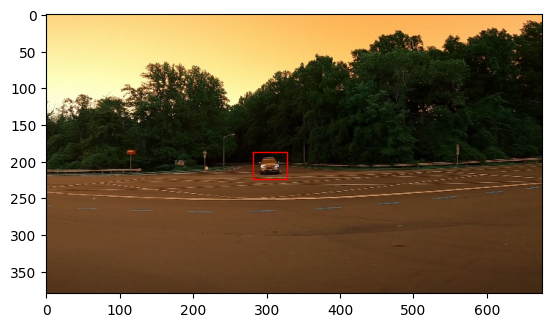

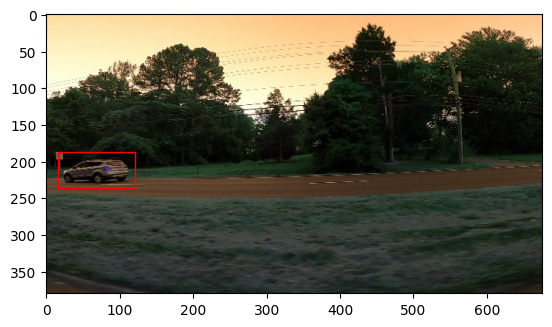

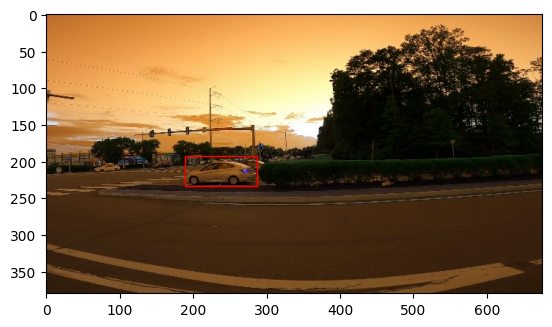

In [10]:
for i in range(len(img_ids)):
    visualize_bbox(imgs[i], bboxs[i])

Convert to matrix form

In [11]:
filelist_df = df['image_id'].to_numpy()
filelist_df[:5]


array(['vid_4_1000', 'vid_4_10000', 'vid_4_10040', 'vid_4_10020',
       'vid_4_10060'], dtype=object)

In [12]:
filelist_big = glob.glob(f'{data_path}/training_images/*')

In [13]:
filelist = []

In [14]:
for file in filelist_df:
  if f'{data_path}/training_images/{file}.jpg' in filelist_big:
    filelist.append(file)

In [15]:
x_train = np.array([np.array(Image.open(f'{data_path}/training_images/{fname}.jpg')) for fname in filelist])

In [16]:
y_train = df[["image_id", "x_center", "y_center", "w", "h"]].to_numpy()

In [17]:
x_train.shape, y_train.shape

((559, 380, 676, 3), (559, 5))

## **Make the model**

For the model, we will start by using a backbone (e.g. a DenseNet model with weights from training on imagenet).  This backbone processes the input image and generates high-level feature representations, which we will then give to the YOLO network. 

In [18]:
def yolo_head(inputs, num_classes, num_bboxes, grid_size):
    x = Conv2D(512, kernel_size=1, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D((num_classes + 5) * num_bboxes, kernel_size=1, strides=1, padding='same')(x)

    output = Reshape((grid_size, grid_size, num_bboxes, num_classes + 5))(x)

    return output

In [19]:
def create_yolo_model(backbone, num_classes, num_bboxes, grid_size):
    inputs = Input(shape=(None, None, 3))
    x = backbone(inputs)
    outputs = yolo_head(x, num_classes, num_bboxes, grid_size)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
# Load a pre-trained backbone network (e.g., DenseNet-53)
backbone = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(None, None, 3))

# Set the number of classes, number of bounding boxes per cell, and grid size
num_classes = 1
num_bboxes = 5
grid_size = 13

# Create the YOLO model
yolo_model = create_yolo_model(backbone, num_classes, num_bboxes, grid_size)
yolo_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 conv2d (Conv2D)             (None, None, None, 512)   524800    
                                                                 
 batch_normalization (BatchN  (None, None, None, 512)  2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 512)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 30)    15390  

#**Define the loss function**

**Note from ChatGPT about the objectness mask (it had me confused so I got more info on it)**:
 objectness mask `objectness_mask` is used to differentiate between grid cells that contain an object and those that do not. It plays a crucial role in calculating the YOLO loss function, specifically in the confidence and classification loss components.

The objectness mask is created by extracting the objectness (confidence) values from the ground truth tensor y_true. These values are either 1 or 0, where 1 indicates that the grid cell contains an object, and 0 indicates that it does not.

Here's a brief explanation of how the objectness mask is used in the YOLO loss function:

Confidence loss: The objectness mask helps calculate two different confidence losses for each bounding box prediction: one for when the grid cell contains an object (objectness = 1) and another for when it does not (objectness = 0). The confidence loss is then computed as a combination of these two losses, with the no-object confidence loss (objectness = 0) being weighted by a hyperparameter lambda_noobj to control its contribution to the total loss.

Classification loss: The objectness mask is used to ensure that the classification loss is only computed for grid cells that contain an object. By element-wise multiplying the objectness mask with the classification loss, we ensure that the classification loss for grid cells without objects (objectness = 0) becomes zero and does not affect the total loss.

In summary, the objectness mask is an essential part of the YOLO loss function, helping to differentiate between grid cells with and without objects and ensuring that the confidence and classification loss components are calculated correctly.

In [21]:
def yolo_loss(y_true, y_pred, num_classes, num_bboxes, grid_size, anchors, lambda_coord=5.0, lambda_noobj=0.5):
    # ... Implement the YOLO loss function ...
    # This should include localization loss, confidence loss, and classification loss.

    # Reshape y_true and y_pred to be easier to work with
    y_true = K.reshape(y_true, (-1, grid_size, grid_size, num_bboxes, num_classes + 5))
    y_pred = K.reshape(y_pred, (-1, grid_size, grid_size, num_bboxes, num_classes + 5))

    # Extract the objectness mask from y_true
    objectness_mask = y_true[..., 4:5]

    # Calculate the localization loss
    localization_loss = K.sum(objectness_mask * (K.square(y_true[..., 0:2] - y_pred[..., 0:2]) + K.square(K.sqrt(y_true[..., 2:4]) - K.sqrt(y_pred[..., 2:4]))))

    # Calculate the confidence loss
    pred_box_conf = y_pred[..., 4:5]
    true_box_conf = objectness_mask * K.expand_dims(K.max(y_true[..., 5:], axis=-1), axis=-1)
    noobj_mask = K.abs(objectness_mask - 1)
    confidence_loss = K.sum(objectness_mask * K.square(true_box_conf - pred_box_conf) + lambda_noobj * noobj_mask * K.square(true_box_conf - pred_box_conf))

    # Calculate the classification loss
    classification_loss = K.sum(objectness_mask * K.square(y_true[..., 5:] - y_pred[..., 5:]))

    # Calculate the total loss
    loss = lambda_coord * localization_loss + confidence_loss + classification_loss


    return loss

# Compile Model

The `anchors` variable represents the anchor boxes used in the YOLO model. Anchor boxes are pre-defined bounding box shapes that help the model predict object bounding boxes more accurately. They are typically determined by analyzing the aspect ratios and sizes of bounding boxes in the training dataset. You can either define the anchor boxes yourself or use the ones provided in the YOLO paper or other YOLO implementations.

In [22]:
anchors = [
    (1.08, 1.19),
    (3.42, 4.41),
    (6.63, 11.38),
    (9.42, 5.11),
    (16.62, 10.52),
]

In [23]:
yolo_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                   loss=lambda y_true, y_pred: yolo_loss(y_true, y_pred, num_classes, num_bboxes, grid_size, anchors))

In [25]:
yolo_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 conv2d (Conv2D)             (None, None, None, 512)   524800    
                                                                 
 batch_normalization (BatchN  (None, None, None, 512)  2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 512)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 30)    15390     
                                                             

In [27]:
x_train.shape, y_train.shape

((559, 380, 676, 3), (559, 5))

In [24]:
# Set the batch size and the number of epochs
batch_size = 32
epochs = 100

# Train the model
history = yolo_model.fit(
    x=x_train,         
    y=y_train,         
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,  
    callbacks=[tf.keras.callbacks.ModelCheckpoint('yolo_model.h5', save_best_only=True, monitor='val_loss')],
)

ValueError: ignored